In [138]:
import numpy as np
import tqdm
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [192]:
class CluGame():
    def __init__(self):
        # define the game parameters
        self.categories = [9,6,6]
        n_cards = sum(self.categories)
        self.n_players = 4
        
        self.game_array = np.zeros((self.n_players+2, n_cards), dtype=int)
        self.game_array[-2,:] = 1
        # first rows are players, last two are discard pile and envelope
        
        # pick cards from each category for the envelope
        for cati in range(len(self.categories)):
            first_card = sum(self.categories[:cati])
            last_card = first_card + self.categories[cati]
            rand_card = random.randint(first_card, last_card-1)
            self.game_array[:, rand_card] = 0
            self.game_array[-1, rand_card] = 1
        
        # distribute the remaining cards to the players
        self.cards_per_player = (n_cards - len(self.categories)) // self.n_players
        self.player_knowledge = []
        for player in range(self.n_players):
            for _ in range(self.cards_per_player):
                while True:
                    rand_card = random.randint(0, n_cards-1)
                    if self.game_array[-2, rand_card] == 1: # card is available to pick
                        self.game_array[:, rand_card] = 0
                        self.game_array[player, rand_card] = 1
                        break
                    
        
        knowledge_template = np.zeros_like(self.game_array, dtype=float)
        knowledge_template[-2,:] = self.game_array[-2,:] # discard pile is known to all players
        self.player_knowledge = [knowledge_template.copy() for _ in range(self.n_players)]
        for player in range(self.n_players):
            self.player_knowledge[player][player,:] = self.game_array[player,:] # each player knows their own cards
            for card in range(n_cards):
                if self.player_knowledge[player][:, card].sum() == 0: # card is not known
                    self.player_knowledge[player][:, card] += 0.1
                    self.player_knowledge[player][player, card] = 0 # player knows they don't have this card
                    self.player_knowledge[player][-2, card] = 0 # player knows this card is not in the discard pile
    
    def normalize_knowledge(self):
        for player in range(self.n_players):
            for _ in range(40): # repeat normalizations to ensure convergence
                
                # only one of each card exists
                self.player_knowledge[player] /= self.player_knowledge[player].sum(axis=0, keepdims=True)
                
                # only one of each category in the envelope
                for cati in range(len(self.categories)):
                    first_card = sum(self.categories[:cati])
                    last_card = first_card + self.categories[cati]
                    self.player_knowledge[player][-1, first_card:last_card] /= self.player_knowledge[player][-1, first_card:last_card].sum()
                
                # each player has the same number of cards
                for player2 in range(self.n_players):
                    self.player_knowledge[player][player2,:] *= self.cards_per_player / self.player_knowledge[player][player2,:].sum()
    
    def ask_turn(self, player, cards):
        # player asks if other players have any of the cards in the list
        for player_offset in range(self.n_players - 1):
            player2 = (player + player_offset + 1) % self.n_players
            
            held_cards = [card for card in cards if self.game_array[player2, card] == 1]
            if len(held_cards) > 0:
                revealed_card = self.reveal_logic(player, held_cards)
                
                #player2 has revealed the card to player
                self.player_knowledge[player][:, revealed_card] = 0
                self.player_knowledge[player][player2, revealed_card] = 1
                
                for other_player in range(self.n_players):
                    if other_player != player2 and other_player != player:
                        current_card_knowledge = 0
                        for card in cards:
                            current_card_knowledge += self.player_knowledge[other_player][player2, card]                            
                        
                        if current_card_knowledge < 1: # current model of knowledge doesn't fit, at least one of the cards must be held by player2
                            for card in cards:
                                self.player_knowledge[other_player][player2, card] /= current_card_knowledge
                break # only one player can be asked at a time
            else: # player2 doesn't have any of the cards asked for
                for other_player in range(self.n_players):
                    for card in cards:
                        self.player_knowledge[other_player][player2, card] = 0
    
    def reveal_logic(self, player, cards):
        return random.choice(cards)
    
    def ask_logic(self, player):
        card_selection = []
        for i in range(len(self.categories)):
            card_selection.append(random.randint(0, self.categories[i]-1) + sum(self.categories[:i]))
        return card_selection
        #return random.sample(range(self.game_array.shape[1]), 3)
    
    def display_knowledge(self):
        plt.figure(figsize=(10, 10))
        plt.subplots(self.n_players)
        for player in range(self.n_players):
            plt.subplot(self.n_players, 1, player+1)
            plt.imshow(self.player_knowledge[player])
            plt.title(f'Player {player}')
        plt.colorbar()
        plt.show()

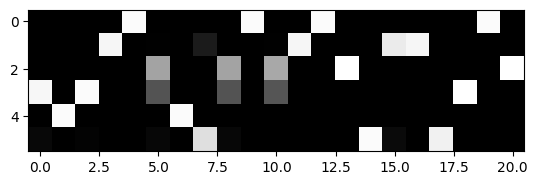

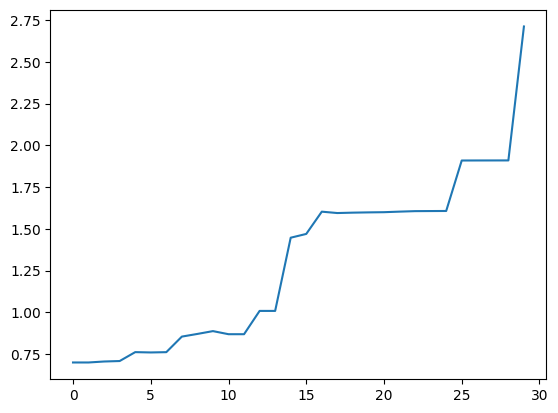

In [200]:
game = CluGame()
game.normalize_knowledge()
prediction_dev = []

#import time

#random.seed(0)
player = 0
for turns in range(30):
    cards = game.ask_logic(player)
    game.ask_turn(player, cards)
    game.normalize_knowledge()
    prediction_dev.append((game.player_knowledge[0][-1, :]**2).sum())
    
    player = (player + 1) % game.n_players
    clear_output(wait=True)
    plt.imshow(game.player_knowledge[0], cmap='grey')
    plt.show()
    #time.sleep(0.3)
    
#game.display_knowledge()

plt.plot(prediction_dev)